# Testing and evaluation
This notebook tests the models and parameters computed in [setup_feature_training.ipynb](https://github.com/sertansenturk/dlfm_makam_recognition/blob/master/setup_feature_training.ipynb) using the features also computed in the same notebook. Next, it aggregates the obtained results and evaluates the models/parameters.

That that we also apply the testing on the training recordings too, in order to obtain the training accuracy

In [1]:
%matplotlib inline
import os
import itertools
import json
import numpy as np
from matplotlib import pyplot as plt
from dlfm_code.tester import plot_min_peak_ratio
from fileoperations.fileoperations import get_filenames_in_dir


## Setup the cluster

In [2]:
# ipyparallel
import ipyparallel

# get the clients
clients = ipyparallel.Client()
print(clients.ids)

# create a direct view into the engines
dview = clients.direct_view()

with dview.sync_imports():
    from dlfm_code.trainer import compute_recording_distributions
    from dlfm_code.trainer import train_single
    from dlfm_code.trainer import train_multi 
    from dlfm_code.tester import search_min_peak_ratio
    from dlfm_code.tester import test
    from dlfm_code.tester import evaluate
    
# dummy method to check that the cluster works properly
def dummy(x):
    return x+2
print dview.map_sync(dummy, range(0,10))
    

[0, 1, 2, 3, 4, 5, 6, 7]
importing compute_recording_distributions from dlfm_code.trainer on engine(s)
importing train_single from dlfm_code.trainer on engine(s)
importing train_multi from dlfm_code.trainer on engine(s)
importing search_min_peak_ratio from dlfm_code.tester on engine(s)
importing test from dlfm_code.tester on engine(s)
importing evaluate from dlfm_code.tester on engine(s)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


## Set the dataset, feature and training model paths and define the parameters

In [3]:
# parameters
distribution_types = ['pd', 'pcd']
step_sizes = [7.5, 15.0, 25.0, 50.0, 100.0]
kernel_widths = [0, 7.5, 15.0, 25.0, 50.0, 100.0]
model_types = ['single', 'multi']

# path the experimental data is saved
save_path = os.path.join('.', 'data')


## Optimize *min_peak_ratio*
This parameter is used in tonic identification and joint estimation to consider the minimum peak height wrt the highest peak to be selected as a tonic candidate. We check in how many recordings the peak is among the peaks obtained above the *min_peak_ratio* and total the number of peaks that is detected above the *min_peak_ratio*. We would like to have the number of peaks as small as possible: **1)** for time and computational performance, **2)** to increase the prior probabilty of selecting the correct tonic among the selected peaks.

We search the *min_peak_ratio* from 0 (i.e. no thresholding) to 1 (i.e. selecting the pitch or pitch-class of the highest peak directly as the tonic) with 0.05 hops. We consider all the *kernel_width*s, *distribution_type*s. We only consider the *bin_size*s cents as max error introduced by the bin size (i.e. *step_size* / 2) for higher *step_size* values is close to or exceeds the distance tolerance between the annotated and the estimated tonic frequencies (25 cents) in the evaluation of tonic identification.

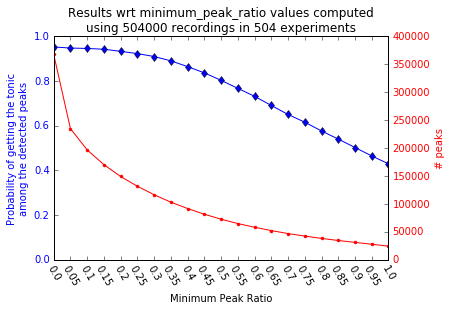

In [4]:
## get all the combinations for the selected parameters
min_peak_ratios = np.arange(0, 1.01, 0.05).tolist()

pcombs = list(
    itertools.product([7.5, 15.0], kernel_widths, distribution_types, min_peak_ratios))
# ignore combinations in which kernel_width is three times less than the step_size
pcombs = [c for c in pcombs if c[1] == 0 or 3 * c[1] >= c[0]]
pcombs = np.array(pcombs, dtype='object').transpose().tolist()

# get the number of recordings where the tonic is among the peaks vs.
# the total number of peaks for each experiment
tmp_peak = dview.map_sync(search_min_peak_ratio, *pcombs)

# accumulate the numbers
num_tonic = np.zeros(len(min_peak_ratios))
num_peak = np.zeros(len(min_peak_ratios))
for i, (t, p) in enumerate(tmp_peak):
    # print '%d, %d, %.2f' %(t, p, pcombs[-1][i])
    idx = np.where(np.isclose(min_peak_ratios, pcombs[-1][i]))
    num_tonic[idx] += t
    num_peak[idx] += p
ratio_tonic = num_tonic / (1000.0 * len(pcombs[-1]) / len(min_peak_ratios))   
prob_tonic = num_tonic / num_peak

# plot tonic percentage and number of peaks vs minimum peak ratio
plot_min_peak_ratio(min_peak_ratios, ratio_tonic, num_peak, 
                    num_exps=len(pcombs[0]))
# plt.savefig('./data/testing/min_peak_ratio.pdf', bbox_inches='tight')
plt.show()

## Testing Parameters

From the figure, we can observe that the probability of having the tonic is among the detected peaks does not have a substatial drop from 0 to 0.35 *minimum_peak_ratio*. In the meantime there is a substantial drop in the number of detected peaks with respect to 0 when we increase the *minimum_peak_ratio*. Depending on the application any *minimum_peak_ratio* can be selected. We select *minimum_peak_ratio* as **0.15**, since our scenario can tolerate longer processing time for better accuracy.

Below we list the parameters to be optimized. Note that the training parameters are listed above.

In [5]:
# experimental setup
experiment_types = ['tonic', 'mode', 'joint']
fold_idx = np.arange(0, 10, 1)

# testing parameters
dis_measures = ['l1', 'l2', 'l3', 'bhat', 'dis_intersect', 'dis_corr']
k_neighbors = [1, 3, 5, 10, 15]
min_peak_ratios = [0.15]
ranks = [5]


# Testing

Here we generate the iterators for all the combinations and test them one by one. 
**Note 1:** Testing all the parameters will **take ages**, unless you use a cluster.


In [6]:
# get all the combinations.
tcombs = itertools.product(step_sizes, kernel_widths, distribution_types, model_types, 
                           fold_idx, experiment_types, dis_measures, k_neighbors, 
                           min_peak_ratios, ranks, [save_path])
# eliminate cases with kernel_width less than one third of step_size
# eliminate cases where single model_type is not called with 1 nearest neighbor
tcombs = itertools.ifilter(lambda c: (c[1] == 0 or 3 * c[1] >= c[0]) and
                           (c[3] == 'multi' or c[7] == 1), tcombs)
tcombs = itertools.izip(*tcombs)
print "Running experiments"

test_result = dview.map_sync(test, *tcombs)

Running experiments


# Evaluation

In [7]:
# get all the combinations.
tcombs = itertools.product(step_sizes, kernel_widths, distribution_types, model_types, 
                           experiment_types, dis_measures, k_neighbors, 
                           min_peak_ratios, [save_path])
# eliminate cases with kernel_width less than one third of step_size
# eliminate cases where single model_type is not called with 1 nearest neighbor
tcombs = itertools.ifilter(lambda c: (c[1] == 0 or 3 * c[1] >= c[0]) and
                           (c[3] == 'multi' or c[6] == 1), tcombs)
tcombs = itertools.izip(*tcombs)
print "Evaluating the experiments"

test_result = dview.map_sync(evaluate, *tcombs)


Evaluating the experiments
